# FIne-Tunning Text Classifier for more than 1 input

### Example applications:

1. (From instructors) Multiple choice questions: pass as inputs the questions and possible answers, and the model will predict the correct answer.
2. (From instructors) Chatbot with past context: pass past conversation as input
3. (From instructors) QUestion-answering: answer a question along with the passage of text that contains the answer. The model will select the portion of the text where the answer are.

### Task: what are other use cases for Multi-Input Text Classifier?

2. 

### But how can we change the number of inputs?

Remember: Fine-Tunning generally is to keep all the network (including forst layer) the same and only update weights of the last layer.

Answer: we don't need to! We can simply concatenate entries.

It might work with RNN too. Exercise: Think about how that moight work in RNN!

### Recall BERT

BERT is pre-trained in unsupervised NLP tasks.

BRET is pre-trained in two tasks: Next Sentence Prediction (NSP) and textual entailment

In order to train NSP, we build a binary classifier whether the second sentence follows the first one

We use formatted text as following:

"[CLS] This is the sentence one. [SEP] This is the sentence two. [SEP]"

The difference from textual entailment and NSP is the task: now you want to know if the first sentence entails the second sentence.

As in NSP, we train a binary classificator.

Tradução: Queremos saber se a primeira sentença ocasiona a segunda.

Ex.: "Bob buys a car" entails "Bob owns a car".
Ex.? "Bob purchased cheese" doesn't entails "Bob doesn't have cheese"

### Task

#### Compare BERT and DistilBERT

Bert uses the input token_type_id, while DistilBERT doesn't.

Your task is:
1. Check if "token_type_id" is present in BERT, but not in DistilBERT.
2. compare both BERT and DistilBERT in terms of time of execution and 

# Part 1. Warmup!

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


import torch
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np


Since the dataset ("glue", "rte") didn't have labels for the loaded test split at the moment of this notebook was created, we will split train data in train and test data, instead of use the loaded test data

In [2]:
raw_dataset_temp = load_dataset("glue", "rte", split=["train", "validation"])
raw_dataset_temp

[Dataset({
     features: ['sentence1', 'sentence2', 'label', 'idx'],
     num_rows: 2490
 }),
 Dataset({
     features: ['sentence1', 'sentence2', 'label', 'idx'],
     num_rows: 277
 })]

In [3]:
raw_dataset = raw_dataset_temp[0].train_test_split(test_size=250, seed=42)
raw_dataset['validation'] = raw_dataset_temp[1]
del raw_dataset_temp
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
})

In [37]:
def get_class_balance(dataset):
  """Gets the class balance of a dataset."""
  class_counts = {}
  for sample in dataset:
    if sample["label"] not in class_counts:
      class_counts[sample["label"]] = 0
    class_counts[sample["label"]] += 1

  return {
      label: count / len(dataset)
      for label, count in class_counts.items()
  }

print("Train set balance:")
print(get_class_balance(raw_dataset["train"]))
print("Validation set balance:")
print(get_class_balance(raw_dataset["validation"]))
print("Test set balance:")
print(get_class_balance(raw_dataset["test"]))

Train set balance:
{1: 0.5022321428571429, 0: 0.49776785714285715}
Validation set balance:
{1: 0.4729241877256318, 0: 0.5270758122743683}
Test set balance:
{0: 0.536, 1: 0.464}


### Note:

We now have two input sentences is a label!

In [4]:
checkpoint_BERT = "bert-base-cased"
checkpoint_DistilBERT = "distilbert-base-cased"

In [5]:
tokenizer_BERT = AutoTokenizer.from_pretrained(checkpoint_BERT)
tokenizer_DistilBERT = AutoTokenizer.from_pretrained(checkpoint_DistilBERT)

In [6]:
sentence_1 = raw_dataset['train']['sentence1'][0]
sentence_2 = raw_dataset['train']['sentence2'][0]
sentence_1, sentence_2

('A small bronze bust of Spencer Tracy sold for £174,000.',
 'A small bronze bust of Spencer Tracy made £180,447.')

In [7]:
result_BERT = tokenizer_BERT(sentence_1, sentence_2)
result_BERT

{'input_ids': [101, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1962, 1111, 15142, 1559, 1527, 117, 1288, 119, 102, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1189, 15142, 18910, 117, 3140, 1559, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
result_BERT.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
tokenizer_BERT.decode(result_BERT['input_ids'])

'[CLS] A small bronze bust of Spencer Tracy sold for £174, 000. [SEP] A small bronze bust of Spencer Tracy made £180, 447. [SEP]'

In [10]:
result_DistilBERT = tokenizer_DistilBERT(sentence_1, sentence_2)
result_DistilBERT

{'input_ids': [101, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1962, 1111, 15142, 1559, 1527, 117, 1288, 119, 102, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1189, 15142, 18910, 117, 3140, 1559, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
result_DistilBERT.keys()

dict_keys(['input_ids', 'attention_mask'])

In [12]:
tokenizer_DistilBERT.decode(result_DistilBERT['input_ids'])

'[CLS] A small bronze bust of Spencer Tracy sold for £174, 000. [SEP] A small bronze bust of Spencer Tracy made £180, 447. [SEP]'

### ✅ Task 1

In [13]:
def get_tokenize_fn(tokenizer):
    def tokenize_fn(batch):
        return tokenizer(batch['sentence1'], batch['sentence2'], truncation=True)
    
    return tokenize_fn

In [14]:
tokenize_fn = get_tokenize_fn(tokenizer_BERT)
tokenized_datasets = raw_dataset.map(tokenize_fn, batched=True)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [15]:
raw_dataset['train'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'not_entailment'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [16]:
raw_dataset['train'][25]

{'sentence1': 'Hovind, self-styled as "Dr. Dino" (whose Ph.D, from a non-accredited correspondence university, is in Christian education) believes in Biblical literalism claimed that he is not liable for taxes and his "ministry" does not have to "render unto Caesar" because, as he claimed, his workers are "missionaries" not "employees". Hovind\'s tax troubles date back to at least 1996, when a judge at Hovind\'s bankruptcy trial wrote, Hovind "failed to acknowledge his obligations as a citizen and taxpayer of the United States, seeks to utilize this taxpayer supported court in order to thwart the lawful collection efforts of the Internal Revenue Service." The judge concluded, Hovind filed for bankruptcy in "bad faith," and lied about his possessions and income.',
 'sentence2': 'Hovind  was found guilty on 59 federal counts.',
 'label': 1,
 'idx': 878}

In [17]:
del tokenize_fn
del tokenized_datasets

In [18]:
metric = load_metric("glue", "rte")
metric

/tmp/ipykernel_40251/3426014769.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "rte")


Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

In [19]:

# def compute_metrics(logits_and_labels):
#     logits, labels = logits_and_labels
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)


def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": acc, "f1": f1}

In [20]:
def evalCheckpoints(ckpt_path, checkpoints, tokenizer, tokenized_datasets):
    columns = ["eval_accuracy", "eval_f1", "eval_loss"]
    results = pd.DataFrame(columns=columns, index=checkpoints)
    for _ckpt in checkpoints:
        model = AutoModelForSequenceClassification.from_pretrained(
            ckpt_path + "/" + _ckpt, num_labels=2
        )
        training_args = TrainingArguments(
            output_dir=ckpt_path,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
        )

        def compute_metrics(logits_and_labels):
            logits, labels = logits_and_labels
            predictions = np.argmax(logits, axis=-1)
            acc = np.mean(predictions == labels)
            f1 = f1_score(labels, predictions, average="macro")
            return {"accuracy": acc, "f1": f1}

        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        result = {k: v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)
    # Plot the evaluation results

    plt.figure(figsize=(10, 6))
    sn.lineplot(x="checkpoint", y="eval_f1", data=results, label="F1 Score")
    sn.lineplot(x="checkpoint", y="eval_accuracy", data=results, label="Accuracy Score")
    # sn.lineplot(x="checkpoint", y="eval_loss", data=results)
    plt.title("Evaluation Metrics")
    plt.show()


### Exercise: complete the notebook on my OWN, before looking at the notebook!

# Part 2: Complete by my own!

## 2.1. Let's do the task for BERT

In [21]:
tokenize_fn_BERT = get_tokenize_fn(tokenizer_BERT)

tokenized_datasets_BERT = raw_dataset.map(tokenize_fn_BERT, batched=True)
tokenized_datasets_BERT

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [22]:
model_BERT = AutoModelForSequenceClassification.from_pretrained(checkpoint_BERT, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args_BERT = TrainingArguments(
    "training_dir_rte_BERT",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    logging_strategy="epoch",
    seed=42,
)

In [24]:
trainer_BERT = Trainer(
    model_BERT,
    training_args_BERT,
    train_dataset=tokenized_datasets_BERT['train'],
    eval_dataset=tokenized_datasets_BERT['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_BERT,
)

In [25]:
trainer_BERT.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1400 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7039, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6890738606452942, 'eval_accuracy': 0.48014440433212996, 'eval_f1': 0.35246753246753243, 'eval_runtime': 2.2532, 'eval_samples_per_second': 122.936, 'eval_steps_per_second': 2.219, 'epoch': 1.0}
{'loss': 0.6831, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6676690578460693, 'eval_accuracy': 0.6064981949458483, 'eval_f1': 0.5972387113986527, 'eval_runtime': 2.4467, 'eval_samples_per_second': 113.215, 'eval_steps_per_second': 2.044, 'epoch': 2.0}
{'loss': 0.6223, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6936220526695251, 'eval_accuracy': 0.631768953068592, 'eval_f1': 0.6300282840980516, 'eval_runtime': 2.617, 'eval_samples_per_second': 105.847, 'eval_steps_per_second': 1.911, 'epoch': 3.0}
{'loss': 0.4709, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.8904157280921936, 'eval_accuracy': 0.6498194945848376, 'eval_f1': 0.6179527648622902, 'eval_runtime': 2.6977, 'eval_samples_per_second': 102.68, 'eval_steps_per_second': 1.853, 'epoch': 4.0}
{'loss': 0.333, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 1.0219002962112427, 'eval_accuracy': 0.6606498194945848, 'eval_f1': 0.6382003112494441, 'eval_runtime': 2.6001, 'eval_samples_per_second': 106.536, 'eval_steps_per_second': 1.923, 'epoch': 5.0}
{'train_runtime': 313.2823, 'train_samples_per_second': 35.75, 'train_steps_per_second': 4.469, 'train_loss': 0.5626424080984933, 'epoch': 5.0}


TrainOutput(global_step=1400, training_loss=0.5626424080984933, metrics={'train_runtime': 313.2823, 'train_samples_per_second': 35.75, 'train_steps_per_second': 4.469, 'train_loss': 0.5626424080984933, 'epoch': 5.0})

In [26]:
!ls training_dir_rte_BERT

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1120  checkpoint-280  checkpoint-840
checkpoint-1400  checkpoint-560


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-280         0.488  0.370525  0.685627
1   checkpoint-560         0.624  0.616038    0.6513
2   checkpoint-840         0.644  0.642714  0.682196
3  checkpoint-1120          0.66  0.630171  0.856269
4  checkpoint-1400         0.688     0.675  0.981474


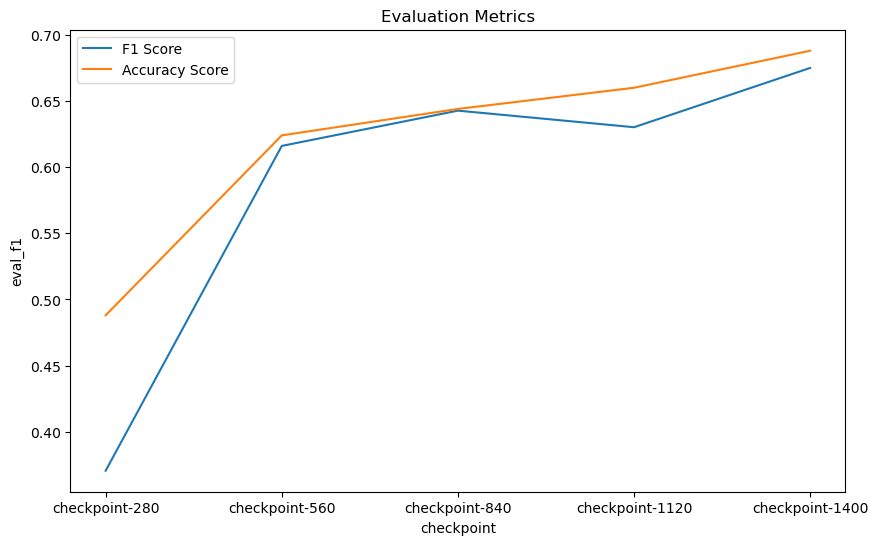

In [27]:
evalCheckpoints(
    ckpt_path="training_dir_rte_BERT",
    checkpoints=[
        "checkpoint-280",
        "checkpoint-560",
        "checkpoint-840",
        "checkpoint-1120",
        "checkpoint-1400",
        # "checkpoint-1680",
    ],
    tokenizer=tokenizer_BERT,
    tokenized_datasets=tokenized_datasets_BERT,
)


In [28]:
savedModel_BERT = pipeline('text-classification', model="training_dir_rte_BERT/checkpoint-1120", device=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [29]:
# Look how this will not work:
savedModel_BERT("I like eggs", "I like ham")

Ignoring args : ('I like ham',)


[{'label': 'LABEL_1', 'score': 0.7764352560043335}]

In [30]:
# This works! (following course QA: https://www.udemy.com/course/data-science-transformers-nlp/learn/lecture/31655016#questions/17845422)

savedModel_BERT({'text': "I don't like fruits", 'text_pair': "I like apple"})

{'label': 'LABEL_1', 'score': 0.9305574893951416}

In [31]:
preds = savedModel_BERT(
    [
        {"text": t, "text_pair": t_pair}
        for t, t_pair in zip(
            raw_dataset["test"]["sentence1"], raw_dataset["test"]["sentence2"]
        )
    ]
)

preds[:10]


[{'label': 'LABEL_0', 'score': 0.931443989276886},
 {'label': 'LABEL_0', 'score': 0.9130197167396545},
 {'label': 'LABEL_0', 'score': 0.9282119870185852},
 {'label': 'LABEL_1', 'score': 0.8148350715637207},
 {'label': 'LABEL_1', 'score': 0.9485133290290833},
 {'label': 'LABEL_1', 'score': 0.9396941065788269},
 {'label': 'LABEL_0', 'score': 0.9261466264724731},
 {'label': 'LABEL_1', 'score': 0.8279871940612793},
 {'label': 'LABEL_0', 'score': 0.93309086561203},
 {'label': 'LABEL_0', 'score': 0.9293855428695679}]

In [32]:
preds_labels = [int(d['label'].split('_')[1]) for d in preds]
preds_labels[:10]

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0]

Acc.: 0.66
F1.: 0.6301710785081536


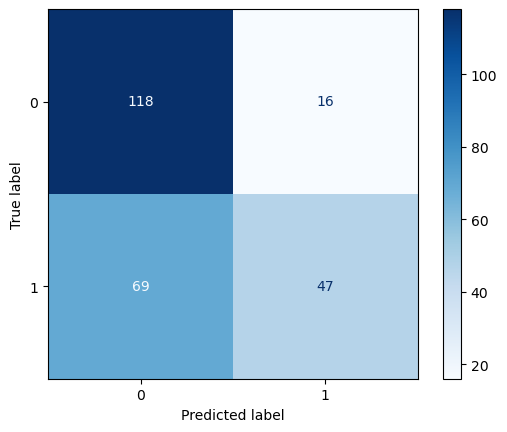

In [33]:
print(f"Acc.: {accuracy_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels)}")
print(f"F1.: {f1_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels, average='macro')}")

cm = confusion_matrix(y_true=raw_dataset['test']['label'], y_pred=preds_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [34]:
# We need to free memory, since it uses gigabytes of memory
!rm -rf ./training_dir_rte_BERT

# del python variables, specially those that are getting lots of GPU memory
del tokenizer_BERT
del tokenize_fn_BERT
del training_args_BERT
del trainer_BERT
del savedModel_BERT
del model_BERT
del preds

## 2.2. Let's do the task for DistilBERT

In [21]:
tokenize_fn_DistilBERT = get_tokenize_fn(tokenizer_DistilBERT)

tokenized_datasets_DiltilBERT = raw_dataset.map(tokenize_fn_DistilBERT, batched=True)
tokenized_datasets_DiltilBERT

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [22]:
model_DistilBERT = AutoModelForSequenceClassification.from_pretrained(checkpoint_DistilBERT, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args_DistilBERT = TrainingArguments(
    "training_dir_rte_DistilBERT",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    logging_strategy="epoch",
    seed=42,
)

In [25]:
trainer_DistilBERT = Trainer(
    model_DistilBERT,
    training_args_DistilBERT,
    train_dataset=tokenized_datasets_DiltilBERT['train'],
    eval_dataset=tokenized_datasets_DiltilBERT['validation'],
    tokenizer=tokenizer_DistilBERT,
    compute_metrics=compute_metrics,
)

In [26]:
# pytorch clear GPU memory
torch.cuda.empty_cache()

In [27]:

trainer_DistilBERT.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/700 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6989, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.717296838760376, 'eval_accuracy': 0.4729241877256318, 'eval_f1': 0.321078431372549, 'eval_runtime': 1.3603, 'eval_samples_per_second': 203.634, 'eval_steps_per_second': 3.676, 'epoch': 1.0}
{'loss': 0.669, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6763392090797424, 'eval_accuracy': 0.5740072202166066, 'eval_f1': 0.5686041600675746, 'eval_runtime': 1.3671, 'eval_samples_per_second': 202.621, 'eval_steps_per_second': 3.657, 'epoch': 2.0}
{'loss': 0.4545, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.8025107383728027, 'eval_accuracy': 0.6137184115523465, 'eval_f1': 0.6132143183390101, 'eval_runtime': 1.1633, 'eval_samples_per_second': 238.126, 'eval_steps_per_second': 4.298, 'epoch': 3.0}
{'loss': 0.2234, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 1.2093250751495361, 'eval_accuracy': 0.6101083032490975, 'eval_f1': 0.5755873340143003, 'eval_runtime': 1.373, 'eval_samples_per_second': 201.75, 'eval_steps_per_second': 3.642, 'epoch': 4.0}
{'loss': 0.1118, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 1.4420864582061768, 'eval_accuracy': 0.6353790613718412, 'eval_f1': 0.6209746250660453, 'eval_runtime': 1.1519, 'eval_samples_per_second': 240.479, 'eval_steps_per_second': 4.341, 'epoch': 5.0}
{'train_runtime': 145.6528, 'train_samples_per_second': 76.895, 'train_steps_per_second': 4.806, 'train_loss': 0.4315331540788923, 'epoch': 5.0}


TrainOutput(global_step=700, training_loss=0.4315331540788923, metrics={'train_runtime': 145.6528, 'train_samples_per_second': 76.895, 'train_steps_per_second': 4.806, 'train_loss': 0.4315331540788923, 'epoch': 5.0})

In [28]:
!ls training_dir_rte_DistilBERT

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-140	checkpoint-280	checkpoint-420	checkpoint-560	checkpoint-700


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

       checkpoint eval_accuracy   eval_f1 eval_loss
0  checkpoint-140         0.464   0.31694  0.720516
1  checkpoint-280         0.588  0.582381  0.674801
2  checkpoint-420         0.632  0.631976  0.809292
3  checkpoint-560         0.688  0.667553  1.030257
4  checkpoint-700         0.668  0.658824  1.280911


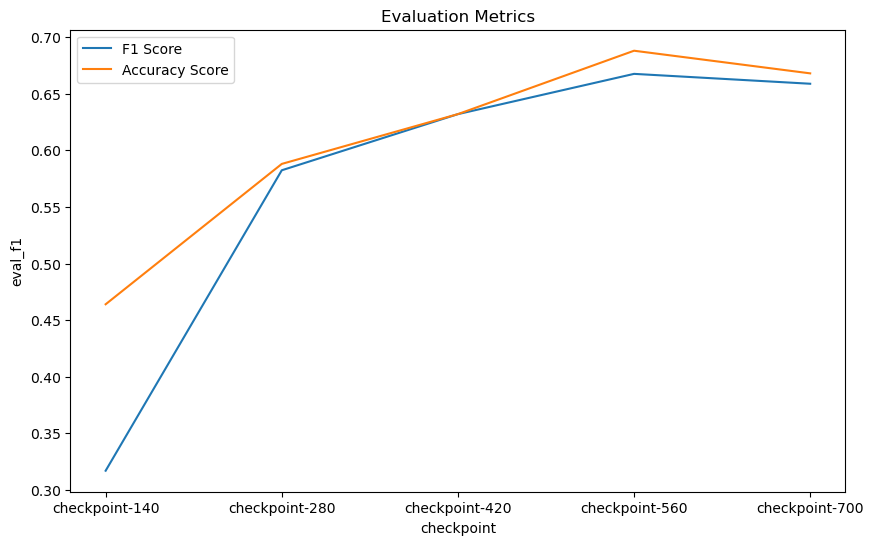

In [29]:
evalCheckpoints(
    ckpt_path="training_dir_rte_DistilBERT",
    checkpoints=[
        "checkpoint-140",
        "checkpoint-280",
        "checkpoint-420",
        "checkpoint-560",
        "checkpoint-700",
        # "checkpoint-840",
        # "checkpoint-980",
        # "checkpoint-1120",
        # "checkpoint-1260",
        # "checkpoint-1400",
    ],
    tokenizer=tokenizer_DistilBERT,
    tokenized_datasets=tokenized_datasets_DiltilBERT,
)


In [31]:
savedModel_DistilBERT = pipeline('text-classification', model="training_dir_rte_DistilBERT/checkpoint-560", device=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [32]:
preds = savedModel_DistilBERT(
    [
        {"text": t, "text_pair": t_pair}
        for t, t_pair in zip(
            raw_dataset["test"]["sentence1"], raw_dataset["test"]["sentence2"]
        )
    ]
)
preds[:10]

[{'label': 'LABEL_0', 'score': 0.9684305191040039},
 {'label': 'LABEL_0', 'score': 0.9886943697929382},
 {'label': 'LABEL_0', 'score': 0.9884907007217407},
 {'label': 'LABEL_1', 'score': 0.9584172964096069},
 {'label': 'LABEL_1', 'score': 0.6339986324310303},
 {'label': 'LABEL_1', 'score': 0.5334056615829468},
 {'label': 'LABEL_0', 'score': 0.6203221678733826},
 {'label': 'LABEL_0', 'score': 0.9657711386680603},
 {'label': 'LABEL_0', 'score': 0.9828762412071228},
 {'label': 'LABEL_0', 'score': 0.9805253148078918}]

In [33]:
preds_labels = [int(d['label'].split('_')[1]) for d in preds]
preds_labels[:10]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

Acc.: 0.688
F1.: 0.6675531914893618


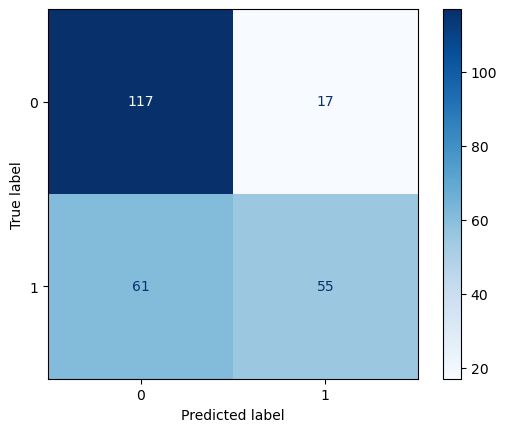

In [34]:
print(f"Acc.: {accuracy_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels)}")
print(f"F1.: {f1_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels, average='macro')}")

cm = confusion_matrix(y_true=raw_dataset['test']['label'], y_pred=preds_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [35]:
# We need to free memory, since it uses gigabytes of memory
!rm -rf ./training_dir_rte_DistilBERT

# del python variables, specially those that are getting lots of GPU memory
del tokenizer_DistilBERT
del tokenize_fn_DistilBERT
del training_args_DistilBERT
del trainer_DistilBERT
del savedModel_DistilBERT
del model_DistilBERT
del preds